## 專案訓練流程總覽
- 載入 BTC / ETH 技術與價格特徵，合併每日新聞情緒特徵，形成單一表格
- 依日期排序並產生兩種標籤：漲跌方向 (direction_label) 與 1 日波動幅度 (vol_label)
- 挑選情緒、價格/報酬、技術、時間數值欄位作為模型特徵，排除日期與標籤欄
- 以時間序 70%/15%/15% 切分 train/val/test，避免未來資訊外洩
- 建立與比較模型：邏輯迴歸、XGBoost 分類 (方向)；XGBoostRegressor (波動)
- 以分類準確率/AUC 與回歸 MAE/RMSE 評估，並觀察特徵重要度作解釋
- 後續可針對不同幣別各自訓練並記錄最佳超參數與測試表現


## 1. Load BTC/ETH price features & daily sentiment features

We merge:
- Technical indicators (SMA, RSI, MACD, volatility…)
- News-based features (DailySentimentMean, PositiveRatio, NewsCount, SentimentZScore)
- Raw price data

Goal:
Prepare a single clean DataFrame for modeling.


In [1]:
import pandas as pd
import numpy as np

btc = pd.read_csv("data\BTC_features.csv", parse_dates=["date"])
eth = pd.read_csv("data\ETH_features.csv", parse_dates=["date"])
daily_sent = pd.read_csv("data\daily_sentiment_features.csv", parse_dates=["date"])

btc_train = btc.merge(daily_sent, on="date", how="left")
eth_train = eth.merge(daily_sent, on="date", how="left")

btc_train.head()

,open,high,low,close,volume,adjusted,date,day_of_week,weekend,daily_return,...,volatility_21d,volume_zscore,volume_change,day_of_week_num,DailySentimentMean,DailySentimentMedian,PositiveRatio,NegativeRatio,NewsCount,SentimentZScore
0,98496.42969,99655.50000,97222.66406,98997.66406,7.847358e+10,98997.66406,2024-11-22,Friday,0,0.005004,...,0.033622,0.173963,-0.259858,4,0.085320,0.0000,0.400000,0.100000,10.0,-0.258922
1,99006.74219,99014.67969,97232.89063,97777.28125,4.441464e+10,97777.28125,2024-11-23,Saturday,1,-0.012327,...,0.033972,-0.942472,-0.434018,5,0.020225,0.0000,0.250000,0.250000,4.0,-0.651242
2,97778.09375,98647.17969,95788.07813,98013.82031,5.171202e+10,98013.82031,2024-11-24,Sunday,1,0.002419,...,0.033666,-0.755736,0.164301,6,0.058533,0.0000,0.333333,0.333333,3.0,-0.420362
3,98033.44531,98935.03125,92642.91406,93102.29688,8.090946e+10,93102.29688,2024-11-25,Monday,0,-0.050111,...,0.036206,0.143731,0.564616,0,0.371638,0.3119,0.625000,0.000000,8.0,1.466682
4,93087.28125,94991.75000,90770.81250,91985.32031,9.165652e+10,91985.32031,2024-11-26,Tuesday,0,-0.011997,...,0.036663,0.444454,0.132828,1,0.088889,0.0000,0.222222,0.000000,9.0,-0.237413


## 2. Create prediction targets (labels)

We generate two targets:
### (a) Direction Prediction (Classification)
- `direction_label = 1` if tomorrow's close > today's close  
- `direction_label = 0` otherwise  

### (b) Volatility Prediction (Regression)
- `vol_label`: absolute return (|next_close - close|)

This matches the evaluation plan:
- Logistic Regression / XGBoost → classification
- XGBoostRegressor → volatility regression


In [3]:
def create_labels(df):
  
    df = df.sort_values("date").copy()
    
    # Tomorrow's close based on the specified close column
    df["close_tmr"] = df['close'].shift(-1)
    
    # Binary direction label: 1 = up, 0 = down or flat
    df["direction_label"] = (df["close_tmr"] > df['close']).astype(int)
    
    # Volatility label: absolute 1-day price change
    df["vol_label"] = (df["close_tmr"] - df['close']).abs()
    
    return df

# Apply to BTC and ETH with their specific column names
btc_train = create_labels(btc_train)
eth_train = create_labels(eth_train)

btc_train

,open,high,low,close,volume,adjusted,date,day_of_week,weekend,daily_return,...,day_of_week_num,DailySentimentMean,DailySentimentMedian,PositiveRatio,NegativeRatio,NewsCount,SentimentZScore,close_tmr,direction_label,vol_label
0,98496.42969,99655.50000,97222.66406,98997.66406,7.847358e+10,98997.66406,2024-11-22,Friday,0,0.005004,...,4,0.085320,0.00000,0.400000,0.100000,10.0,-0.258922,97777.28125,0,1220.38281
1,99006.74219,99014.67969,97232.89063,97777.28125,4.441464e+10,97777.28125,2024-11-23,Saturday,1,-0.012327,...,5,0.020225,0.00000,0.250000,0.250000,4.0,-0.651242,98013.82031,1,236.53906
2,97778.09375,98647.17969,95788.07813,98013.82031,5.171202e+10,98013.82031,2024-11-24,Sunday,1,0.002419,...,6,0.058533,0.00000,0.333333,0.333333,3.0,-0.420362,93102.29688,0,4911.52343
3,98033.44531,98935.03125,92642.91406,93102.29688,8.090946e+10,93102.29688,2024-11-25,Monday,0,-0.050111,...,0,0.371638,0.31190,0.625000,0.000000,8.0,1.466682,91985.32031,0,1116.97657
4,93087.28125,94991.75000,90770.81250,91985.32031,9.165652e+10,91985.32031,2024-11-26,Tuesday,0,-0.011997,...,1,0.088889,0.00000,0.222222,0.000000,9.0,-0.237413,95962.53125,1,3977.21094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,114129.08590,116078.98440,112291.67970,112956.16410,6.452807e+10,112956.16410,2025-10-28,Tuesday,0,-0.010193,...,1,0.198300,0.05135,0.500000,0.000000,8.0,0.421996,110055.30470,0,2900.85940
341,112921.32810,113642.72660,109368.71880,110055.30470,6.219204e+10,110055.30470,2025-10-29,Wednesday,0,-0.025681,...,2,0.003438,0.00000,0.250000,0.250000,8.0,-0.752419,108305.54690,0,1749.75780
342,110059.19530,111612.35160,106376.68750,108305.54690,6.967396e+10,108305.54690,2025-10-30,Thursday,0,-0.015899,...,3,-0.170750,-0.14055,0.000000,0.750000,4.0,-1.802228,109556.16410,1,1250.61720
343,108304.41410,111031.82030,108288.27340,109556.16410,6.009036e+10,109556.16410,2025-10-31,Friday,0,0.011547,...,4,0.111957,0.00000,0.285714,0.000000,7.0,-0.098383,110064.01560,1,507.85150


## 3. Define feature columns for modeling

We select:
- Price & return features
- Technical indicators
- Volume features
- Time features
- Sentiment features

We explicitly exclude:
- `date` (used for sorting and merging)
- `day_of_week` (string)
- target columns: `close_tmr`, `direction_label`, `vol_label`


In [5]:
# Sentiment features
sent_cols = [
    "DailySentimentMean",
    "DailySentimentMedian",
    "PositiveRatio",
    "NegativeRatio",
    "NewsCount",
    "SentimentZScore",
]

# Price & return features
price_cols = [
    "open",
    "high",
    "low",
    "close",
    "volume",
    "daily_return",
    "log_return",
]

# Technical & volatility features
tech_cols = [
    "SMA_5",
    "SMA_10",
    "SMA_20",
    "EMA_12",
    "RSI_14",
    "MACD_line",
    "MACD_signal",
    "MACD_hist",
    "volatility_7d",
    "volatility_21d",
    "volume_zscore",
    "volume_change",
]

# Time features (numeric)
time_cols = [
    "weekend",
    "day_of_week_num",
]

# Final feature list (shared by BTC and ETH)
feature_cols = sent_cols + price_cols + tech_cols + time_cols

print("Number of features:", len(feature_cols))
feature_cols


Number of features: 27


['DailySentimentMean',
 'DailySentimentMedian',
 'PositiveRatio',
 'NegativeRatio',
 'NewsCount',
 'SentimentZScore',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'daily_return',
 'log_return',
 'SMA_5',
 'SMA_10',
 'SMA_20',
 'EMA_12',
 'RSI_14',
 'MACD_line',
 'MACD_signal',
 'MACD_hist',
 'volatility_7d',
 'volatility_21d',
 'volume_zscore',
 'volume_change',
 'weekend',
 'day_of_week_num']

## 4. Time-based split (train / validation / test)

To avoid data leakage:
- Do NOT shuffle the data
- Sort by `date`
- Use a chronological split:
  - Train: first 70% of rows
  - Validation: next 15%
  - Test: final 15%


In [8]:
def time_split(df, feature_cols):
    """
    Split a time-series DataFrame into train / validation / test subsets.

    - Drops rows with missing features or missing direction_label
    - Sorts by date
    - Uses 70% / 15% / 15% chronological split
    """
    # Drop rows with missing features or labels
    df = df.dropna(subset=feature_cols + ["direction_label"]).copy()
    df = df.sort_values("date")

    n = len(df)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    train = df.iloc[:train_end]
    val   = df.iloc[train_end:val_end]
    test  = df.iloc[val_end:]

    return train, val, test

# Apply to BTC (ETH 同樣做一次即可)
btc_tr, btc_val, btc_test = time_split(btc_train, feature_cols)
btc_tr.shape, btc_val.shape, btc_test.shape

eth_tr, eth_val, eth_test = time_split(eth_train, feature_cols)
eth_tr.shape, eth_val.shape, eth_test.shape


((224, 33), (48, 33), (48, 33))

## 5. Baseline model: Logistic Regression (BTC)

Task:
- Predict `direction_label` (1 = next day up, 0 = down/flat)

Metrics:
- Accuracy
- F1-score
- ROC-AUC


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Prepare BTC train/validation sets
X_train_btc = btc_tr[feature_cols]
y_train_btc = btc_tr["direction_label"]

X_val_btc = btc_val[feature_cols]
y_val_btc = btc_val["direction_label"]

# Initialize and train Logistic Regression
lr_btc = LogisticRegression(max_iter=1000)
lr_btc.fit(X_train_btc, y_train_btc)

# Predictions on validation set
pred_val_btc = lr_btc.predict(X_val_btc)
proba_val_btc = lr_btc.predict_proba(X_val_btc)[:, 1]

# Evaluation metrics
print("BTC - Logistic Regression")
print("Accuracy:", accuracy_score(y_val_btc, pred_val_btc))
print("F1-score:", f1_score(y_val_btc, pred_val_btc))
print("ROC-AUC:", roc_auc_score(y_val_btc, proba_val_btc))


BTC - Logistic Regression
Accuracy: 0.4375
F1-score: 0.6086956521739131
ROC-AUC: 0.4409171075837743


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Prepare ETH train/validation sets
X_train_eth = eth_tr[feature_cols]
y_train_eth = eth_tr["direction_label"]

X_val_eth = eth_val[feature_cols]
y_val_eth = eth_val["direction_label"]

# Initialize and train Logistic Regression
lr_eth = LogisticRegression(max_iter=1000)
lr_eth.fit(X_train_eth, y_train_eth)

# Predictions on validation set
pred_val_eth = lr_eth.predict(X_val_eth)
proba_val_eth = lr_eth.predict_proba(X_val_eth)[:, 1]

# Evaluation metrics
print("ETH - Logistic Regression")
print("Accuracy:", accuracy_score(y_val_eth, pred_val_eth))
print("F1-score:", f1_score(y_val_eth, pred_val_eth))
print("ROC-AUC:", roc_auc_score(y_val_eth, proba_val_eth))


ETH - Logistic Regression
Accuracy: 0.6041666666666666
F1-score: 0.7397260273972602
ROC-AUC: 0.656084656084656


## 6. Main model: XGBoost (classification, BTC)

We train an XGBoost classifier to predict `direction_label`.
XGBoost can capture nonlinear relationships and interactions between:
- price/technical features
- sentiment features


In [12]:
from xgboost import XGBClassifier

# XGBoost classifier for BTC
xgb_clf_btc = XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
)

xgb_clf_btc.fit(X_train_btc, y_train_btc)

# Validation predictions
pred_val_btc_xgb = xgb_clf_btc.predict(X_val_btc)
proba_val_btc_xgb = xgb_clf_btc.predict_proba(X_val_btc)[:, 1]

print("BTC - XGBoost Classifier")
print("Accuracy:", accuracy_score(y_val_btc, pred_val_btc_xgb))
print("F1-score:", f1_score(y_val_btc, pred_val_btc_xgb))
print("ROC-AUC:", roc_auc_score(y_val_btc, proba_val_btc_xgb))


BTC - XGBoost Classifier
Accuracy: 0.4166666666666667
F1-score: 0.391304347826087
ROC-AUC: 0.3738977072310406


In [13]:
from xgboost import XGBClassifier

# XGBoost classifier for ETH
xgb_clf_eth = XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
)

xgb_clf_eth.fit(X_train_eth, y_train_eth)

# Validation predictions
pred_val_eth_xgb = xgb_clf_eth.predict(X_val_eth)
proba_val_eth_xgb = xgb_clf_eth.predict_proba(X_val_eth)[:, 1]

print("ETH - XGBoost Classifier")
print("Accuracy:", accuracy_score(y_val_eth, pred_val_eth_xgb))
print("F1-score:", f1_score(y_val_eth, pred_val_eth_xgb))
print("ROC-AUC:", roc_auc_score(y_val_eth, proba_val_eth_xgb))


ETH - XGBoost Classifier
Accuracy: 0.5416666666666666
F1-score: 0.5
ROC-AUC: 0.6014109347442681


## 7. Volatility prediction: XGBoostRegressor (BTC)

Task:
- Predict `vol_label` = absolute 1-day price change

Metrics:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)


In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare regression targets
y_train_btc_vol = btc_tr["vol_label"]
y_val_btc_vol = btc_val["vol_label"]

xgb_reg_btc = XGBRegressor(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

xgb_reg_btc.fit(X_train_btc, y_train_btc_vol)

pred_val_btc_vol = xgb_reg_btc.predict(X_val_btc)



mse = mean_squared_error(y_val_btc_vol, pred_val_btc_vol)  # this is MSE
rmse = mse ** 0.5  # or np.sqrt(mse)
print("BTC - XGBoost Regressor (Volatility)")
print("MAE:", mean_absolute_error(y_val_btc_vol, pred_val_btc_vol))
print("RMSE:", rmse)



BTC - XGBoost Regressor (Volatility)
MAE: 1196.3833021982834
RMSE: 1442.7856296415885


In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare regression targets for ETH
y_train_eth_vol = eth_tr["vol_label"]
y_val_eth_vol = eth_val["vol_label"]

xgb_reg_eth = XGBRegressor(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

xgb_reg_eth.fit(X_train_eth, y_train_eth_vol)

pred_val_eth_vol = xgb_reg_eth.predict(X_val_eth)

print("ETH - XGBoost Regressor (Volatility)")

mse = mean_squared_error(y_val_eth_vol, pred_val_eth_vol)  # this is MSE
rmse = mse ** 0.5  # or np.sqrt(mse)

print("MAE:", mean_absolute_error(y_val_eth_vol, pred_val_eth_vol))
print("RMSE:", rmse)



ETH - XGBoost Regressor (Volatility)
MAE: 115.52126622200053
RMSE: 143.6123407905763


## 8. Simple backtest: BTC/ETH directional strategy

Strategy:
- Use XGBoost classifier predictions on the **test set**
- If predicted label = 1 → go long 1 unit for the next day
- If predicted label = 0 → go short 1 unit for the next day

We compare:
- Strategy cumulative return
- Buy-and-hold cumulative return


In [16]:
# Prepare BTC test set
X_test_btc = btc_test[feature_cols]
y_test_btc = btc_test["direction_label"]

# Use XGBoost classifier for signals
btc_test = btc_test.copy()
btc_test["pred_label"] = xgb_clf_btc.predict(X_test_btc)

# Next-day return based on close and close_tmr
btc_test["return_next"] = btc_test["close_tmr"] / btc_test["close"] - 1

# Strategy return: long if pred_label=1, short if pred_label=0
btc_test["position"] = btc_test["pred_label"].replace({0: -1, 1: 1})
btc_test["strategy_ret"] = btc_test["position"] * btc_test["return_next"]

# Cumulative returns
btc_test["cum_strategy"] = (1 + btc_test["strategy_ret"]).cumprod()
btc_test["cum_buyhold"] = (1 + btc_test["return_next"]).cumprod()

btc_test[["date", "cum_strategy", "cum_buyhold"]].tail()


,date,cum_strategy,cum_buyhold
339,2025-10-27,1.186666,0.978758
340,2025-10-28,1.156191,0.953622
341,2025-10-29,1.174573,0.938461
342,2025-10-30,1.161010,0.949297
343,2025-10-31,1.155628,0.953698


In [19]:
# Prepare ETH test set
X_test_eth = eth_test[feature_cols]
y_test_eth = eth_test["direction_label"]

eth_test = eth_test.copy()
eth_test["pred_label"] = xgb_clf_eth.predict(X_test_eth)

# Next-day return for ETH
eth_test["return_next"] = eth_test["close_tmr"] / eth_test["close"] - 1

# Strategy: long if pred_label=1, short if pred_label=0
eth_test["position"] = eth_test["pred_label"].replace({0: -1, 1: 1})
eth_test["strategy_ret"] = eth_test["position"] * eth_test["return_next"]

# Cumulative returns for ETH
eth_test["cum_strategy"] = (1 + eth_test["strategy_ret"]).cumprod()
eth_test["cum_buyhold"] = (1 + eth_test["return_next"]).cumprod()

eth_test[["date", "cum_strategy", "cum_buyhold"]].tail()


,date,cum_strategy,cum_buyhold
339,2025-10-27,1.138503,0.863907
340,2025-10-28,1.161063,0.846788
341,2025-10-29,1.190504,0.825316
342,2025-10-30,1.203868,0.834581
343,2025-10-31,1.195385,0.840461


## 8.1 Plot BTC strategy vs. buy-and-hold


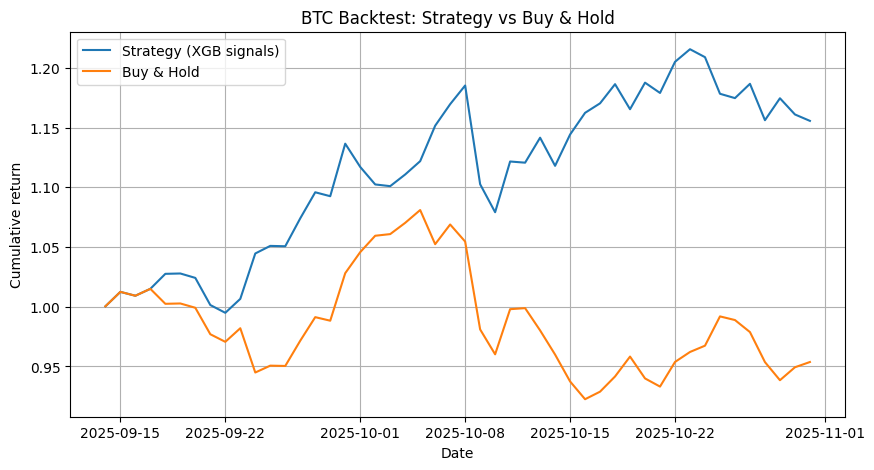

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(btc_test["date"], btc_test["cum_strategy"], label="Strategy (XGB signals)")
plt.plot(btc_test["date"], btc_test["cum_buyhold"], label="Buy & Hold")
plt.legend()
plt.title("BTC Backtest: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.grid(True)
plt.show()


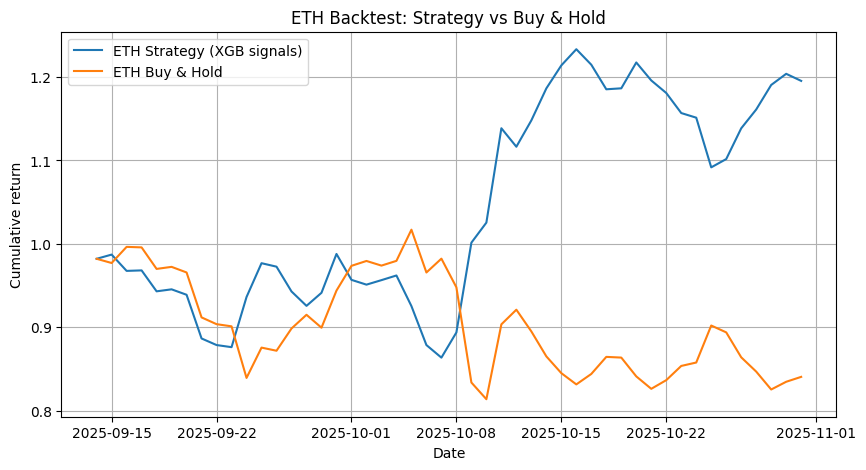

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(eth_test["date"], eth_test["cum_strategy"], label="ETH Strategy (XGB signals)")
plt.plot(eth_test["date"], eth_test["cum_buyhold"], label="ETH Buy & Hold")
plt.legend()
plt.title("ETH Backtest: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.grid(True)
plt.show()